# Определение оттока клиентов в телеком

### Описание задания
Пока создаётся модель прогнозирования оттока клиентов, отдел маркетинга телеком приступает к проработке способов их удержания. Необходимо собрать нужную для этого информацию.

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_contract = pd.read_csv('D:/Data science/data/contract.csv')
df_internet = pd.read_csv('D:/Data science/data/internet.csv')
df_personal = pd.read_csv('D:/Data science/data/personal.csv')
df_phone = pd.read_csv('D:/Data science/data/phone.csv')

In [3]:
df = df_contract.merge(df_personal, on = 'customerID')
df = df.merge(df_internet, on = 'customerID', how = 'left')
df = df.merge(df_phone, on = 'customerID', how = 'left')

In [4]:
df['MultipleLines'] = df['MultipleLines'].fillna('No phone')
df = df.fillna('No')

In [5]:
# Используем категоризацию и "возьмем" из данных информацию о том, ушел ли клиент
def client_outflow(enddate):
    if enddate == 'No':
        return 'No'
    if enddate != 'No':
        return 'Yes'
df['ClientOutflow'] = df['EndDate'].apply(client_outflow)

In [6]:
# в TotalCharges имеются пропуски, сделаем замену
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')

In [7]:
# Так как информация актуальна на 1 февраля 2020, то заменим все значения No в EndDate именно на это число
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01 00:00:00')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')

In [8]:
# Найдем количество месяцев между началом и окончанием договора 
# (в случае действующих пользователей - количество месяцев использования)
df['month'] = ((pd.DatetimeIndex(df['EndDate']).year 
               - pd.DatetimeIndex(df['BeginDate']).year)*12 
               + pd.DatetimeIndex(df['EndDate']).month 
               - pd.DatetimeIndex(df['BeginDate']).month)

In [9]:
# Удалим BeginDate и EndDate
df = df.drop(['BeginDate', 'EndDate'], axis=1)

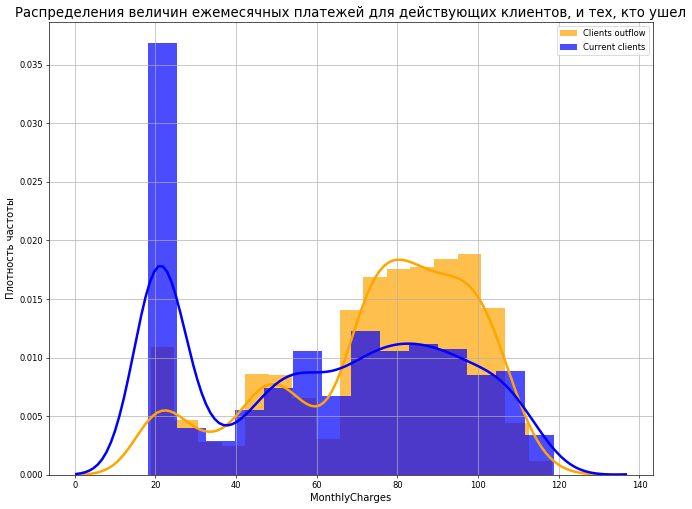

In [10]:
# Построим распределения
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df.loc[df['ClientOutflow'] == 'Yes', 'MonthlyCharges'], 
             color= 'orange', label= 'Clients outflow', 
             hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(df.loc[df['ClientOutflow'] == 'No', 'MonthlyCharges'], 
             color= 'blue', label='Current clients',
             hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
plt.title('Распределения величин ежемесячных платежей для действующих клиентов, и тех, кто ушел', fontsize=16)
plt.ylabel('Плотность частоты', fontsize = 12)
plt.xlabel('MonthlyCharges', fontsize = 12)
plt.grid()
plt.legend()
plt.show()

Довольно интересные биномидальные распределения. Группа клиентов, которые ушли из компании, платили гораздо больше. Вероятно, это связано с подключением дополнительных услуг и высокоскоростного интернета (данный вывод можно сделать и на основе исследовательского анализа, выполненного в "плане работы"). Клиенты, которые остались в компании, в целом платят меньше, чем группа беглецов, за исключением первого пика. Довольно много клиентов, которые остаются в компании, платят по минимальному тарифу. 

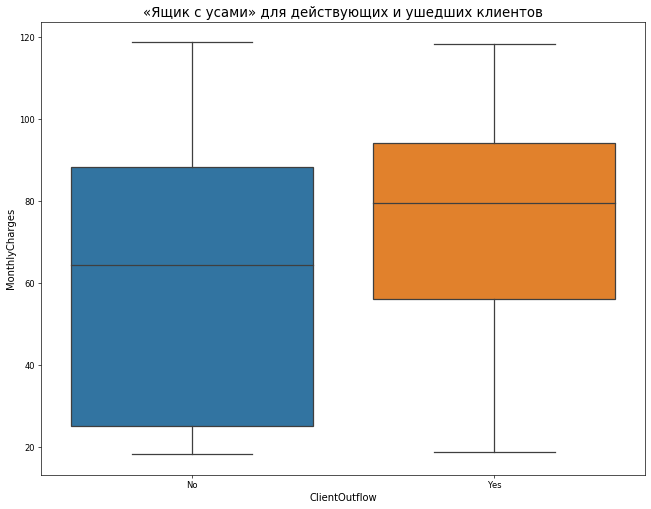

In [11]:
# Построим «ящик с усами»
plt.figure(figsize=(13,10), dpi= 60)
sns.boxplot(x = 'ClientOutflow', y = 'MonthlyCharges', data = df)
plt.title('«Ящик с усами» для действующих и ушедших клиентов', fontsize = 16)
plt.xlabel('ClientOutflow', fontsize = 12)
plt.ylabel('MonthlyCharges', fontsize = 12)
plt.show()

Заметно, что медиана ежемесячных платежей у ушедших клиентов больше, чем у тех, кто остался в компании. Стоит отметить, что интерквартильный размах (25% - 75%) в группе клиентов, которые остались с нами, в ~2 раза больше, чем для второй группы. Это означает, что данные очень разрозненны и, вероятно, можно в этой группе сделать ещё подгруппы, чтобы можно было лучше понять поведение клиентов.

In [12]:
# Сделаем таблицу с квартилями, минимальным и максимальным, а также средним занчением
d1 = df[df['ClientOutflow'] == 'No']['MonthlyCharges'].describe().to_frame().T
d2 = df[df['ClientOutflow'] == 'Yes']['MonthlyCharges'].describe().to_frame().T
d = d1.merge(d2, how = 'outer')
d = d.T
d.columns = ['MonthlyCharges_CurrentClient', 'MonthlyCharges_ClientOutflow']
d

,MonthlyCharges_CurrentClient,MonthlyCharges_ClientOutflow
count,5174.000000,1869.000000
mean,61.265124,74.441332
std,31.092648,24.666053
min,18.250000,18.850000
25%,25.100000,56.150000
50%,64.425000,79.650000
75%,88.400000,94.200000
max,118.750000,118.350000


К сказанному ранее, стоит добавить, среднее значение и медиана выше для группы ушедших клиентов. Такой же эффект наблюдается и для значений 25% (в особенности) и 75% квантилей, то есть опять же подтверждается, что ушедшие клиенты платили больше. 

In [13]:
# Построим графики, показывающие доли клиентов с интернетом и телефонной связью
def internet_used(InternetService):
    if InternetService == 'No':
        return 'No'
    elif InternetService != 'No':
        return 'Yes'
df['internet_used'] = df['InternetService'].apply(internet_used)

def phone_used(MultipleLines):
    if MultipleLines == 'No phone':
        return 'No'
    if MultipleLines != 'No phone':
        return 'Yes'
df['phone_used'] = df['MultipleLines'].apply(phone_used)

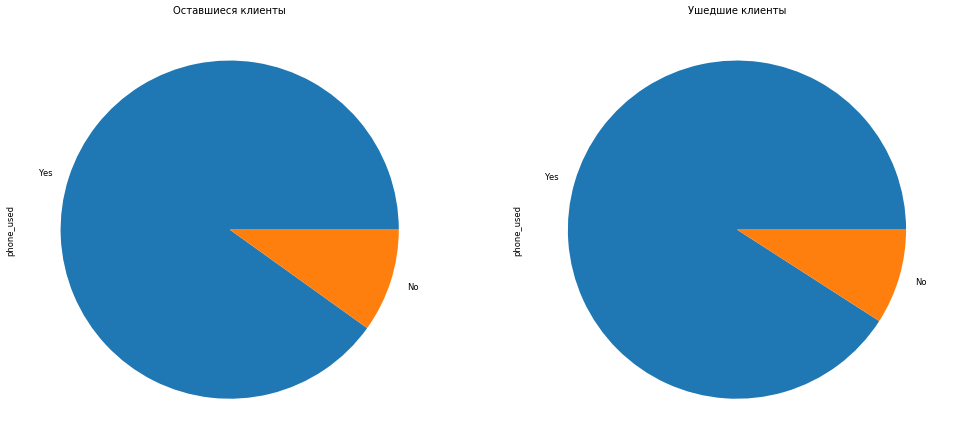

In [14]:
def pieplot(feature):
    plt.figure(figsize=(20,12), dpi= 60)
    plt.subplot(1, 2, 1)
    our_clients = df[df['ClientOutflow'] == 'No'][feature]
    our_clients.value_counts().plot(kind='pie', ax=plt.gca(), title='Оставшиеся клиенты')
    plt.subplot(1, 2, 2)
    clientoutflow = df[df['ClientOutflow'] == 'Yes'][feature]
    clientoutflow.value_counts().plot(kind='pie', ax=plt.gca(), title='Ушедшие клиенты')
    
pieplot('phone_used')

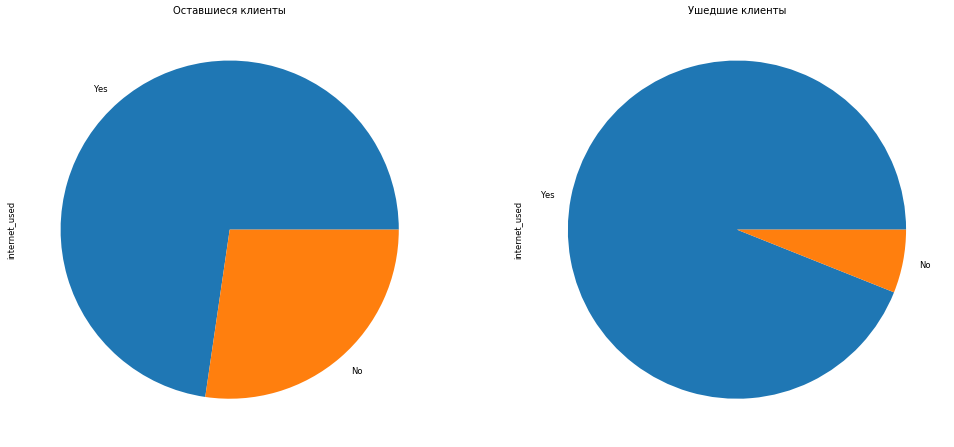

In [15]:
pieplot('internet_used')

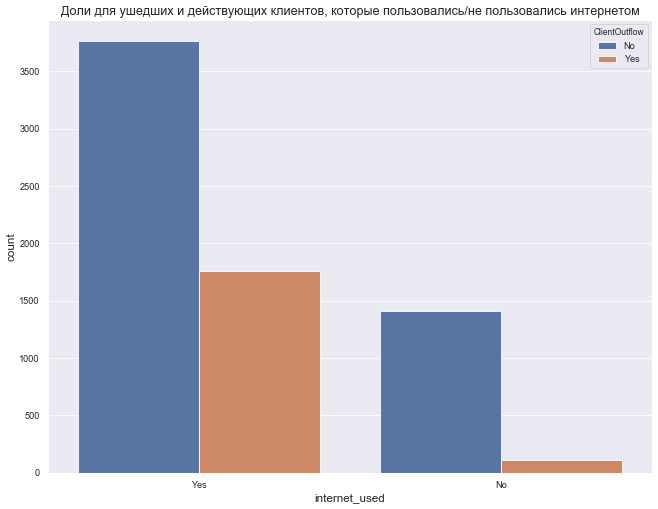

In [16]:
def countplot(feature, hue, title, x):
    plt.figure(figsize=(13,10), dpi= 60)
    sns.set()
    sns.countplot(feature, hue = hue)
    plt.title(title, fontsize = 15)
    plt.xlabel(x, fontsize = 14)
    plt.ylabel('count', fontsize = 14)
countplot(df['internet_used'], df['ClientOutflow'], 'Доли для ушедших и действующих клиентов, которые пользовались/не пользовались интернетом', 'internet_used')

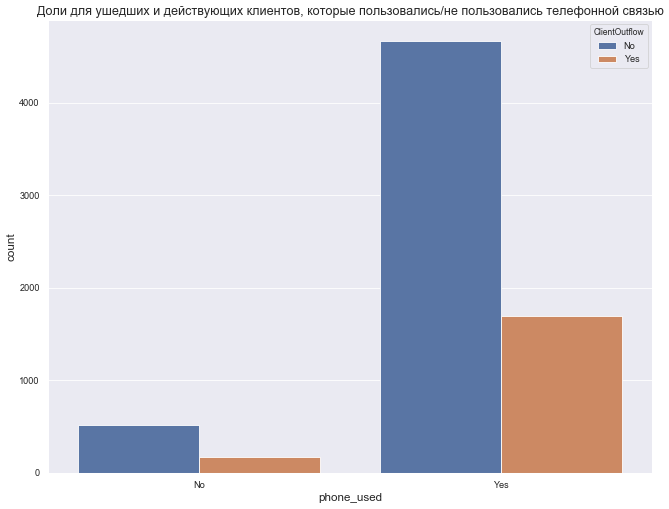

In [17]:
countplot(df['phone_used'], df['ClientOutflow'], 'Доли для ушедших и действующих клиентов, которые пользовались/не пользовались телефонной связью', 'phone_used')

Можно заметить, что наши клиенты в большинстве своем пользуются как интернетом, так и телефонной связью. 
<li> для интернет-пользователей справедливо более высокий относительный отток, чем для клиентов без интернета; </li>
<li> для пользователей телефонной связи относительные оттоки примерно одинаковые. </li>


## Вывод

На основе полученных распределений и графиков можно сделать некоторые рекомендации о том, как можно удержать пользователей, намеревающихся уйти из компании:
<li> в первую очередь было замечено, что чаще уходят те клиенты, которые больше платят за месяц и используют интернет: из этого можно сделать вывод, что необходимо предоставлять скидку на использование интернета потенциально уходящим клиентам; </li>
<li> привлекая сюда исследовательский анализ из "плана работы", можно заключить о том, что основной отток интернет пользоваталей характерен для тех, у кого установлено оптоволокно - это, возможно, означает, что качество интернета неудовлетворительное, либо завышена цена за такое подключение; </li>
<li> если углубиться в анализ интернет-пользователей, то можно заметить, что люди, подключая услуги стримингового тв или фильмов, склонны к уходу из компании </li>
Таким образом, для удержания клиентов необходимо предоставить скидки интернет-пользователям (оптоволокно) - первая мера. Вторая мера - необходимо проанализировать качество интернета и соответствующих услуг. В случае неудовлетворительного результата, улучшить качество этих услуг.